In [ ]:
# Install required libaries
!pip install tweepy
!pip install pandas
!pip install nltk
!pip install wordcloud
!pip install numpy
!pip install gensim
!pip install seaborn
!pip install bokeh
!pip install pyldavis==2.1.2
!pip install spacy-transformers
!python -m spacy download en_core_web_trf

In [1]:
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')
from nltk.stem.porter import *
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors
import seaborn as sns
import pandas as pd
import numpy as np
import os.path
import tweepy
import re
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
from pprint import pprint
import nltk
import spacy
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/abhinav/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
/Users/abhinav/.pyenv/versions/3.8.7/lib/python3.8/site-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/abhinav/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Questions we are looking to answer about the Farmers Protest in India:
1) What are the main concerns or topics that are being discussed related to farmers protest in India - Topic modelling
2) What are the general reaction or sentiment of the crowd towards each topic - Sentiment Analysis
3) Which all celebrities voiced out their opinions about the issue?
4) How does the public (within and/or outside India) feel towards celebrities?

## Set up config information

In [4]:
# CSV Names
RAW_CSV_NAME = "raw_tweets_general_large.csv"
PREPROCESSED_CSV_NAME = "preprocessed_tweets.csv"

# Twitter API Credentials
CONSUMER_KEY = "hnGPJx6xBsudTgwOAxd0UNGUW"
CONSUMER_SECRET = "JcxhisQeF19hlEHRdeBifU3aL4R9DP9BWEMjYJ7MtnGcWaxn0p"
ACCESS_KEY = "1249286455530123264-5LbTPxHcE8Hl3CHhWztOsycMGEViHT"
ACCESS_SECRET = "4vdHhFP3odtZSUAKkK6GgPm7Vl03EHwvbP7cRTLFmQbFf"

pd.set_option('display.max_colwidth', -1)

<ipython-input-4-ae1d02389e4c>:11: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('display.max_colwidth', -1)


## Load Tweets

In [5]:
USE_OLD_CSV = True

if not USE_OLD_CSV or not os.path.isfile(RAW_CSV_NAME):
    # Connect to API
    auth = tweepy.OAuthHandler(CONSUMER_KEY, CONSUMER_SECRET)
    auth.set_access_token(ACCESS_KEY, ACCESS_SECRET)
    api = tweepy.API(auth, wait_on_rate_limit=True, wait_on_rate_limit_notify=True)

    # Query the API
    search_term = "FarmersProtest"
    max_items = 50000
    result_type = "recent"
    lang = "en"
    # Do not include retweets, ensure tweet has 1 minimum retweet and is after September 2020        
    response = tweepy.Cursor(api.search, q=search_term+"-filter:retweets min_retweets:1 since:2020-09-01",
                             result_type=result_type, lang=lang, tweet_mode="extended").items(max_items)

    # Extract only the required keys from the response
    tweets = [
        [tweet.created_at,
         tweet.full_text,
         tweet.retweet_count,
         tweet.favorite_count,
         tweet.user.screen_name,
         tweet.user.followers_count,
         tweet.user.verified,
         tweet.author.location
        ] for tweet in response]

    # Store as CSV for later
    tweets_df = pd.DataFrame(data=tweets, columns=["created_at", "text", "retweet_count", "favorite_count",
    "user_screen_name", "user_followers_count", "user_verified","country"])
    tweets_df.to_csv(RAW_CSV_NAME, quotechar='"', encoding='utf8', index = False, header=True)

raw_tweets = pd.read_csv(RAW_CSV_NAME, quotechar='"', encoding='utf8')

In [6]:
raw_tweets.describe()

,id
count,1.000010e+05
mean,1.369129e+18
std,4.630924e+15
min,1.361272e+18
25%,1.364996e+18
50%,1.368920e+18
75%,1.373364e+18
max,1.377047e+18


## Preprocessing

In [32]:
tweets_df = raw_tweets.copy()
tweets_df['text_processed'] = raw_tweets['content']

# Remove any links
tweets_df['text_processed'] = tweets_df['text_processed'].map(lambda x: re.sub(r'http\S+', '', x))

# Remove any timestamps
tweets_df['text_processed'] = tweets_df['text_processed'].map(lambda x: re.sub(r'[0-9]{1,2}:[0-9]{1,2}:[0-9]{1,2}', '', x))

# Remove punctuation
tweets_df['text_processed'] = tweets_df['text_processed'].map(lambda x: re.sub('[=,:;\\.!|\-\_"}{}]', ' ', x))

# Convert remove apostrophe from words
tweets_df['text_processed'] = tweets_df['text_processed'].map(lambda x: re.sub('[\']', '', x))

# Remove unnecessary line breaks
tweets_df['text_processed'] = tweets_df['text_processed'].map(lambda x: re.sub(r"\n", '', x))

# Remove any emojis or non-english alphabet
# (!) NOTE: this removes hindi words too
tweets_df['text_processed'] = tweets_df['text_processed'].map(lambda x: re.sub(r'[^\x00-\x7F]+', '', x))

# Remove any twitter handles
tweets_df['text_processed'] = tweets_df['text_processed'].map(lambda x: re.sub('@[\w]*', '', x))

# Remove any hashtags
tweets_df['text_processed'] = tweets_df['text_processed'].map(lambda x: re.sub('#[\w]*', '', x))

# Remove leading spaces
tweets_df['text_processed'] = tweets_df['text_processed'].map(lambda x: re.sub(r'^\s+', '', x))

# Remove trailing spaces
tweets_df['text_processed'] = tweets_df['text_processed'].map(lambda x: re.sub(r'[ \t]+$', '', x))

# Remove multi spaces
tweets_df['text_processed'] = tweets_df['text_processed'].map(lambda x: re.sub(' +', ' ', x))

# Remove small words (words like "a", "ok", "are", "in" are useless)
# min_word_length = 3
# tweets_df['text_processed'] = tweets_df['text_processed'].map(lambda x: ' '.join([word for word in x.split() if len(word)>min_word_length]))

# Remove duplicate tweets (keep latest)
tweets_df = tweets_df.drop_duplicates(subset='text_processed', keep="last")

# Remove any empty columns after all the processing
tweets_df['text_processed'].replace('', np.nan, inplace=True)
tweets_df.dropna(subset=['text_processed'], inplace=True)
 
# Store as CSV for later, tweets_df will contain the headers
processed_tweets_df = pd.DataFrame(data=tweets_df)
print(processed_tweets_df['text_processed'].head())
# processed_tweets_df.to_csv(PREPROCESSED_CSV_NAME, quotechar='"', encoding='utf8', index = False, header=True)

/Users/abhinav/.pyenv/versions/3.8.7/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<>:11: DeprecationWarning: invalid escape sequence \-
<>:24: DeprecationWarning: invalid escape sequence \w
<>:27: DeprecationWarning: invalid escape sequence \w
<>:11: DeprecationWarning: invalid escape sequence \-
<>:24: DeprecationWarning: invalid escape sequence \w
<>:27: DeprecationWarning: invalid escape sequence \w
<ipython-input-32-110df1bd9b99>:11: DeprecationWarning: invalid escape sequence \-
  tweets_df['text_processed'] = tweets_df['text_processed'].map(lambda x: re.sub('[=,:;\\.!|\-\_"}{}]', ' ', x))
<ipython-input-32-110df1bd9b99>:24: DeprecationWarning: invalid escape sequence \w
  tweets_df['text

1     With harvesting season approaching the smoke from the faraway fields of Punjab Farmers will trouble Delhi more than the 300 deaths of the Farmers at its doorstep in the                                                        
7     This guy was open giving death threats to people wooah You guys are dead Who are you guys Farmer supporters?People who vote against Modi/RSS? Protestors against farm laws?Sikhs? Punjabis? Democracy loving citizens of Canada?
9     Yes good point                                                                                                                                                                                                                  
13    Nazis kept shouting Hitler Hitler until destruction of the Germany Modi Bhagats are behaving like the same way Godi media is playing the role of Goebels                                                                        
14    Having fought for so long to survive old dirty grandpa Modi just dont 

 ## Word Cloud

/Users/abhinav/.pyenv/versions/3.8.7/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


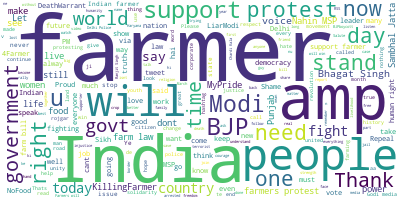

In [33]:
# join the words of the different tweets together into one string
long_string = ' '.join([text for text in processed_tweets_df['text_processed']])
new_long_string = ' '.join(set(long_string.split(" ")))

# create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=1000, contour_width=3, contour_color='steelblue')

# generate a word cloud
wordcloud.generate(long_string)

# visualize the word cloud
wordcloud.to_image()

### Sentiment Analysis of twitter users(unique) towards farmers bill

/Users/abhinav/.pyenv/versions/3.8.7/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/Users/abhinav/.pyenv/versions/3.8.7/lib/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:1434: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  self.tick_pos = ax.

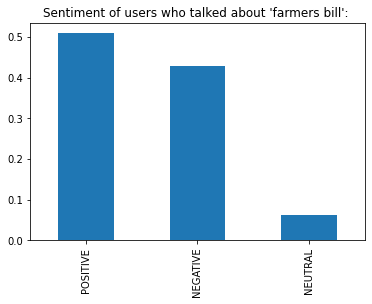

In [40]:
processed_tweets_df.reset_index(drop=True)
processed_total_df = processed_tweets_df.groupby('username')['text_processed'].unique().apply(lambda x: ','.join(x)).reset_index()
sid = SentimentIntensityAnalyzer()
df = pd.DataFrame()
df["text_processed"]=processed_total_df[processed_total_df["text_processed"].str.find(r'bill')!=-1]["text_processed"].to_numpy()
df['scores'] = df['text_processed'].apply(lambda text_processed: sid.polarity_scores(text_processed))

df['compound'] = df['scores'].apply(lambda score_dict: score_dict['compound'])
df['sentiment_type']=''
df.loc[df.compound>0,'sentiment_type']='POSITIVE'
df.loc[df.compound==0 ,'sentiment_type']='NEUTRAL'
df.loc[df.compound<0,'sentiment_type']='NEGATIVE'
df.sentiment_type.value_counts(normalize=True).plot.bar(title="Sentiment of users who talked about 'farmers bill': ")
plt.show()

# Topic Modelling
### To identify the main concerns or topics that are being discussed regarding farmers protest

In [10]:
stop_words = stopwords.words('english')

def sent_to_words(sentences):
  for sentence in sentences:
    yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))

def remove_stopwords(texts):
  return [[word for word in simple_preprocess(str(doc)) 
    if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

data = tweets_df.text_processed.values.tolist()

data_words = list(sent_to_words(data))

# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# remove stop words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

# create a dictionary
id2word = corpora.Dictionary(data_lemmatized)

# create a corpus
texts = data_lemmatized

# convert the corpus into a BoW representation
corpus = [id2word.doc2bow(text) for text in texts]

#Identify TF-IDF and use this as corpus
tfidf = gensim.models.TfidfModel(corpus)
corpus_tfidf = tfidf[corpus]

In [11]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.LdaModel(corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [12]:
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=2, limit=50, step=1)

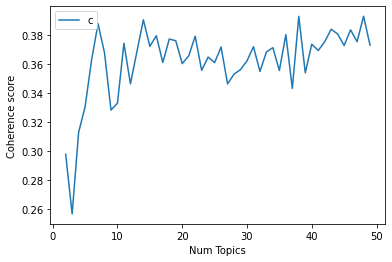

Num Topics = 2  has Coherence Value of 0.2978
Num Topics = 3  has Coherence Value of 0.2567
Num Topics = 4  has Coherence Value of 0.3129
Num Topics = 5  has Coherence Value of 0.3305
Num Topics = 6  has Coherence Value of 0.3628
Num Topics = 7  has Coherence Value of 0.3879
Num Topics = 8  has Coherence Value of 0.3677
Num Topics = 9  has Coherence Value of 0.3282
Num Topics = 10  has Coherence Value of 0.3331
Num Topics = 11  has Coherence Value of 0.3743
Num Topics = 12  has Coherence Value of 0.3463
Num Topics = 13  has Coherence Value of 0.3686
Num Topics = 14  has Coherence Value of 0.3905
Num Topics = 15  has Coherence Value of 0.3722
Num Topics = 16  has Coherence Value of 0.3795
Num Topics = 17  has Coherence Value of 0.3611
Num Topics = 18  has Coherence Value of 0.3772
Num Topics = 19  has Coherence Value of 0.3761
Num Topics = 20  has Coherence Value of 0.3603
Num Topics = 21  has Coherence Value of 0.3657
Num Topics = 22  has Coherence Value of 0.3792
Num Topics = 23  has 

In [13]:
# Show graph
start=2; limit=50; step=1;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

With the coherence score seems to keep increasing with the number of topics, it may make better sense to pick the model that gave the highest CV before flattening out or a major drop. In this case, we picked **k=12**

In [14]:
num_topics=12

In [15]:
# Select the model and print the topics
optimal_model = model_list[10]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

[(0,
  '0.159*"farmer" + 0.051*"support" + 0.041*"protest" + 0.035*"law" + '
  '0.027*"farm" + 0.026*"stand" + 0.021*"india" + 0.018*"right" + 0.017*"food" '
  '+ 0.015*"repeal"'),
 (1,
  '0.031*"world" + 0.027*"day" + 0.021*"singh" + 0.019*"go" + 0.019*"good" + '
  '0.016*"msp" + 0.014*"part" + 0.014*"farmer" + 0.013*"pm" + 0.012*"detain"'),
 (2,
  '0.025*"tweet" + 0.025*"human_right" + 0.020*"do" + 0.018*"true" + '
  '0.017*"always" + 0.015*"s" + 0.013*"write" + 0.013*"see" + 0.013*"year" + '
  '0.012*"wrong"'),
 (3,
  '0.037*"thank" + 0.026*"never" + 0.025*"toolkit" + 0.021*"release" + '
  '0.021*"democracy" + 0.014*"today" + 0.013*"woman" + 0.012*"make" + '
  '0.010*"india" + 0.010*"farmer"'),
 (4,
  '0.041*"farmer" + 0.029*"delhi" + 0.020*"protest" + 0.017*"today" + '
  '0.015*"day" + 0.015*"come" + 0.014*"crop" + 0.014*"get" + 0.013*"time" + '
  '0.013*"border"'),
 (5,
  '0.034*"amp" + 0.027*"voice" + 0.023*"india" + 0.021*"farmer" + 0.021*"need" '
  '+ 0.019*"fight" + 0.017*"sik

### What is the Dominant topic and its percentage contribution in each tweet

In [16]:
def format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=data)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,0.0,0.7163,"farmer, support, protest, law, farm, stand, india, right, food, repeal",With harvesting season approaching the smoke from the faraway fields of Punjab Farmers will trouble Delhi more than the 300 deaths of the Farmers at its doorstep in the
1,1,10.0,0.2377,"india, bjp, people, arrest, police, say, amp, government, call, delhi",This guy was open giving death threats to people wooah You guys are dead Who are you guys Farmer supporters?People who vote against Modi/RSS? Protestors against farm laws?Sikhs? Punjabis? Democracy loving citizens of Canada?
2,2,8.0,0.3630,"journalist, aa, update, waheguru, ho, ne, kaur, twitter, salute, news",Yes good point
3,3,5.0,0.7037,"amp, voice, india, farmer, need, fight, sikh, people, let, raise",Nazis kept shouting Hitler Hitler until destruction of the Germany Modi Bhagats are behaving like the same way Godi media is playing the role of Goebels
4,4,4.0,0.4368,"farmer, delhi, protest, today, day, come, crop, get, time, border",Having fought for so long to survive old dirty grandpa Modi just dont see this government giving a damn about it They force some people to actually take their lives there in the protest sites or when they go back home
5,5,11.0,0.7708,"punjab, kisan, follow, watch, free, video, india, haryana, issue, story",No Religion can be greater than Humanity
6,6,11.0,0.6105,"punjab, kisan, follow, watch, free, video, india, haryana, issue, story",amarinder when would you listen to them &amp treating them well &amp loved like your grand daughter They too are someones family &amp loved children to whom you beat up grab from hair for asking jobs &amp pays that youre holding on of teachers since 2016
7,7,5.0,0.7757,"amp, voice, india, farmer, need, fight, sikh, people, let, raise",If we induldge with a mentally sick person we must have to lose our mental level too wich is neither fair nor we like to be So dont waste time and energy keep distance and ignore mentally sick Modi Bhagats
8,8,9.0,0.4287,"hai, love, jindabaad, m, water, modi, election, desh, remain, believe",Farmers are burdened with debts and bankruptcy If Modi shut down all the schools/colleges how do you expect them to repay without working? Some of the families have taken loans for medical treatments weddings etc Do you see the significant factor here?
9,9,6.0,0.5389,"share, keep, support, court, matter, use, bail, tweet, vote, hashtag",No academic should put up with this Kudos to Dr Truschke for bravely speaking up and standing steadfast in her beliefs and convictions based on extensive study of subject matter in a structured form


### The most representative sentence for each topic

In [17]:
sent_topics_sorteddf_mallet = pd.DataFrame()
sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=False).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Representative Text"]

# Show
sent_topics_sorteddf_mallet

,Topic_Num,Topic_Perc_Contrib,Keywords,Representative Text
0,0.0,0.9563,"farmer, support, protest, law, farm, stand, india, right, food, repeal",three farm bills are like a death warrant say farmers 250+Farmers lost their life during protest Farmers feed the India Fight for them Protect them Respect themWithdraw the 3 black laws&amp make law on MSP
1,1.0,0.9236,"world, day, singh, go, good, msp, part, farmer, pm, detain",In The Journey Of Life Its Not Important To Hold All The Good Relations But Its More Important How Good We Behave With The Relations Which We Hold
2,2.0,0.8854,"tweet, human_right, do, true, always, s, write, see, year, wrong",Loyalty to country ALWAYS Loyalty to government when it deserves it and deserves Juttiyaann
3,3.0,0.9389,"thank, never, toolkit, release, democracy, today, woman, make, india, farmer",Feminism isnt about making women stronger women are already stronger Its about changing the way the world perceives that strength And we can see the power and strength of women in
4,4.0,0.8982,"farmer, delhi, protest, today, day, come, crop, get, time, border",From more than 110 days farmers are at Delhi borders just 16 km away from South block did you meet them??
5,5.0,0.9295,"amp, voice, india, farmer, need, fight, sikh, people, let, raise",Well said but they are not a part of their planning yet coz they dont know anything I was raising voice I am speaking up And till my last breath i will be coz itz our right
6,6.0,0.8977,"share, keep, support, court, matter, use, bail, tweet, vote, hashtag",BharatBandh BharatBandh BharatBandh BharatBandh BharatBandh BharatBandh BharatBandh BharatBandh
7,7.0,0.8981,"modi, win, rojgar, job, peaceful, truth, stay, sambhal_jatta, shame, fight",2024 vijay kala re Stay Together Fight Together Against this Fascist Regime DeathWarrant
8,8.0,0.9390,"journalist, aa, update, waheguru, ho, ne, kaur, twitter, salute, news",Mere dosta di chup nafrat nahi Par dosti di vi eh fitrat nahi Sajda hai jo larrai ch naal kharre ne Ik syaasatdaan hi c koi kudrat nahi
9,9.0,0.9542,"hai, love, jindabaad, m, water, modi, election, desh, remain, believe",Kabhi kabhi mere dil mein khyal aata hai ki agar pakistan aur China hamare padosi nahi hote to bharat k neta bhukke mar jaate LiarModi


### Frequency Distribution of Word Counts in Documents

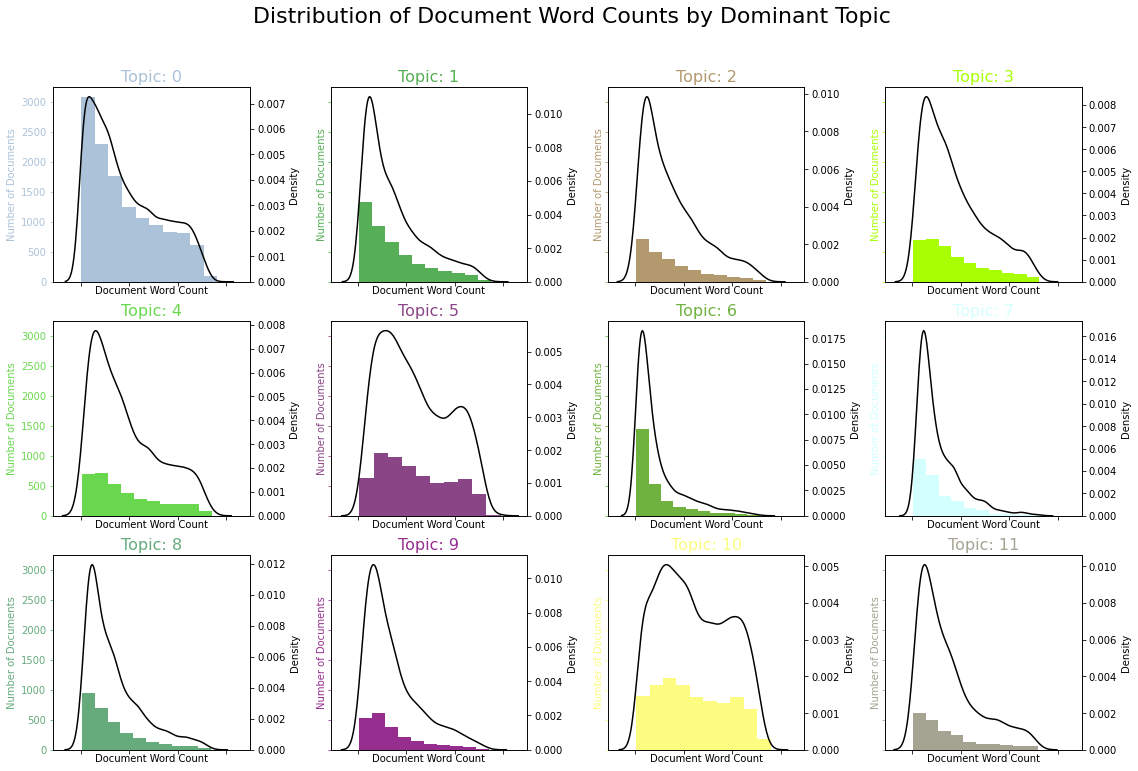

In [18]:
doc_lens = [len(d) for d in df_dominant_topic.Text]
cols = np.array([color for name, color in mcolors.XKCD_COLORS.items()])

fig, axes = plt.subplots((num_topics//4)+1,4,figsize=(16,14), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):  
    if i<num_topics:
        df_dominant_topic_sub = df_dominant_topic.loc[df_dominant_topic.Dominant_Topic == i, :]
        doc_lens = [len(d) for d in df_dominant_topic_sub.Text]
        ax.hist(doc_lens, color=cols[i])
        ax.tick_params(axis='y', labelcolor=cols[i], color=cols[i])
        sns.kdeplot(doc_lens, color="black", shade=False, ax=ax.twinx())
        ax.set(xlabel='Document Word Count')
        ax.set_ylabel('Number of Documents', color=cols[i])
        ax.set_title('Topic: '+str(i), fontdict=dict(size=16, color=cols[i]))
    else:
        ax.set_visible(False)

fig.tight_layout()
fig.subplots_adjust(top=0.90)
fig.suptitle('Distribution of Document Word Counts by Dominant Topic', fontsize=22)
plt.show()

### Word Clouds of Top N Keywords in Each Topic

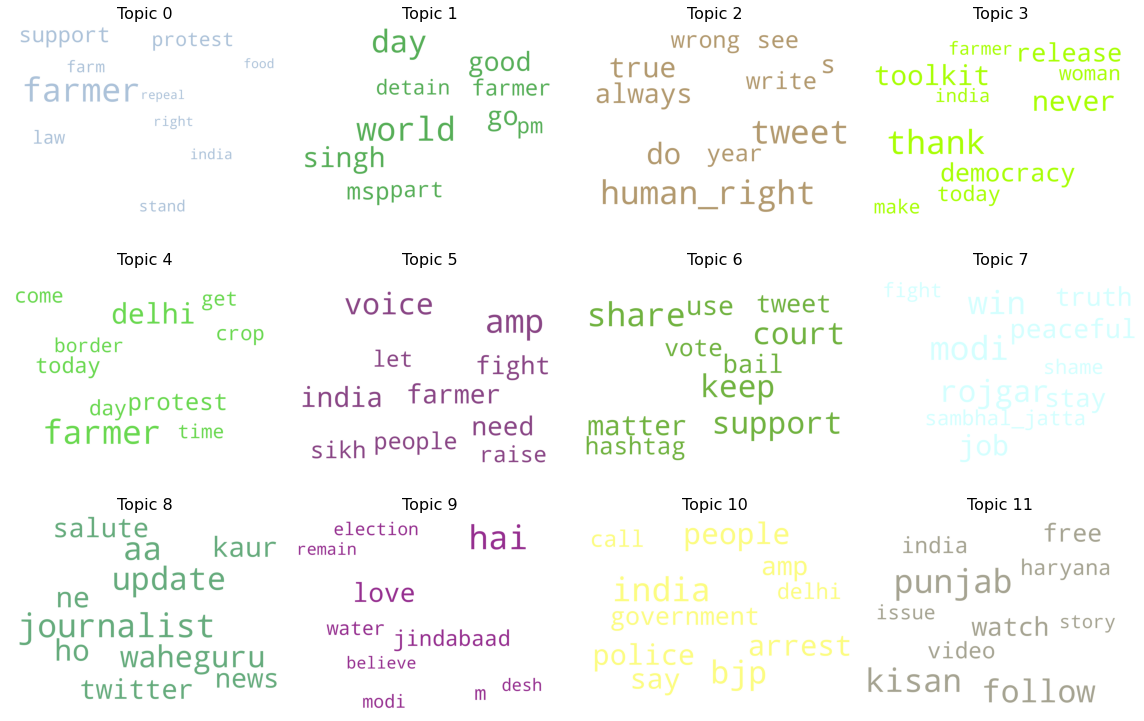

In [19]:
cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = optimal_model.show_topics(formatted=False, num_topics=num_topics, num_words=10)

fig, axes = plt.subplots((num_topics//4)+1, 4, figsize=(16,14), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    if i<num_topics:
        fig.add_subplot(ax)
        topic_words = dict(topics[i][1])
        cloud.generate_from_frequencies(topic_words, max_font_size=300)
        plt.gca().imshow(cloud)
        plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
        plt.gca().axis('off')
    else:
        ax.set_visible(False)


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

### Word Counts of Topic Keywords

<ipython-input-20-c594632555c6>:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
<ipython-input-20-c594632555c6>:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
<ipython-input-20-c594632555c6>:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
<ipython-input-20-c594632555c6>:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
<ipython-input-20-c594632555c6>:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation

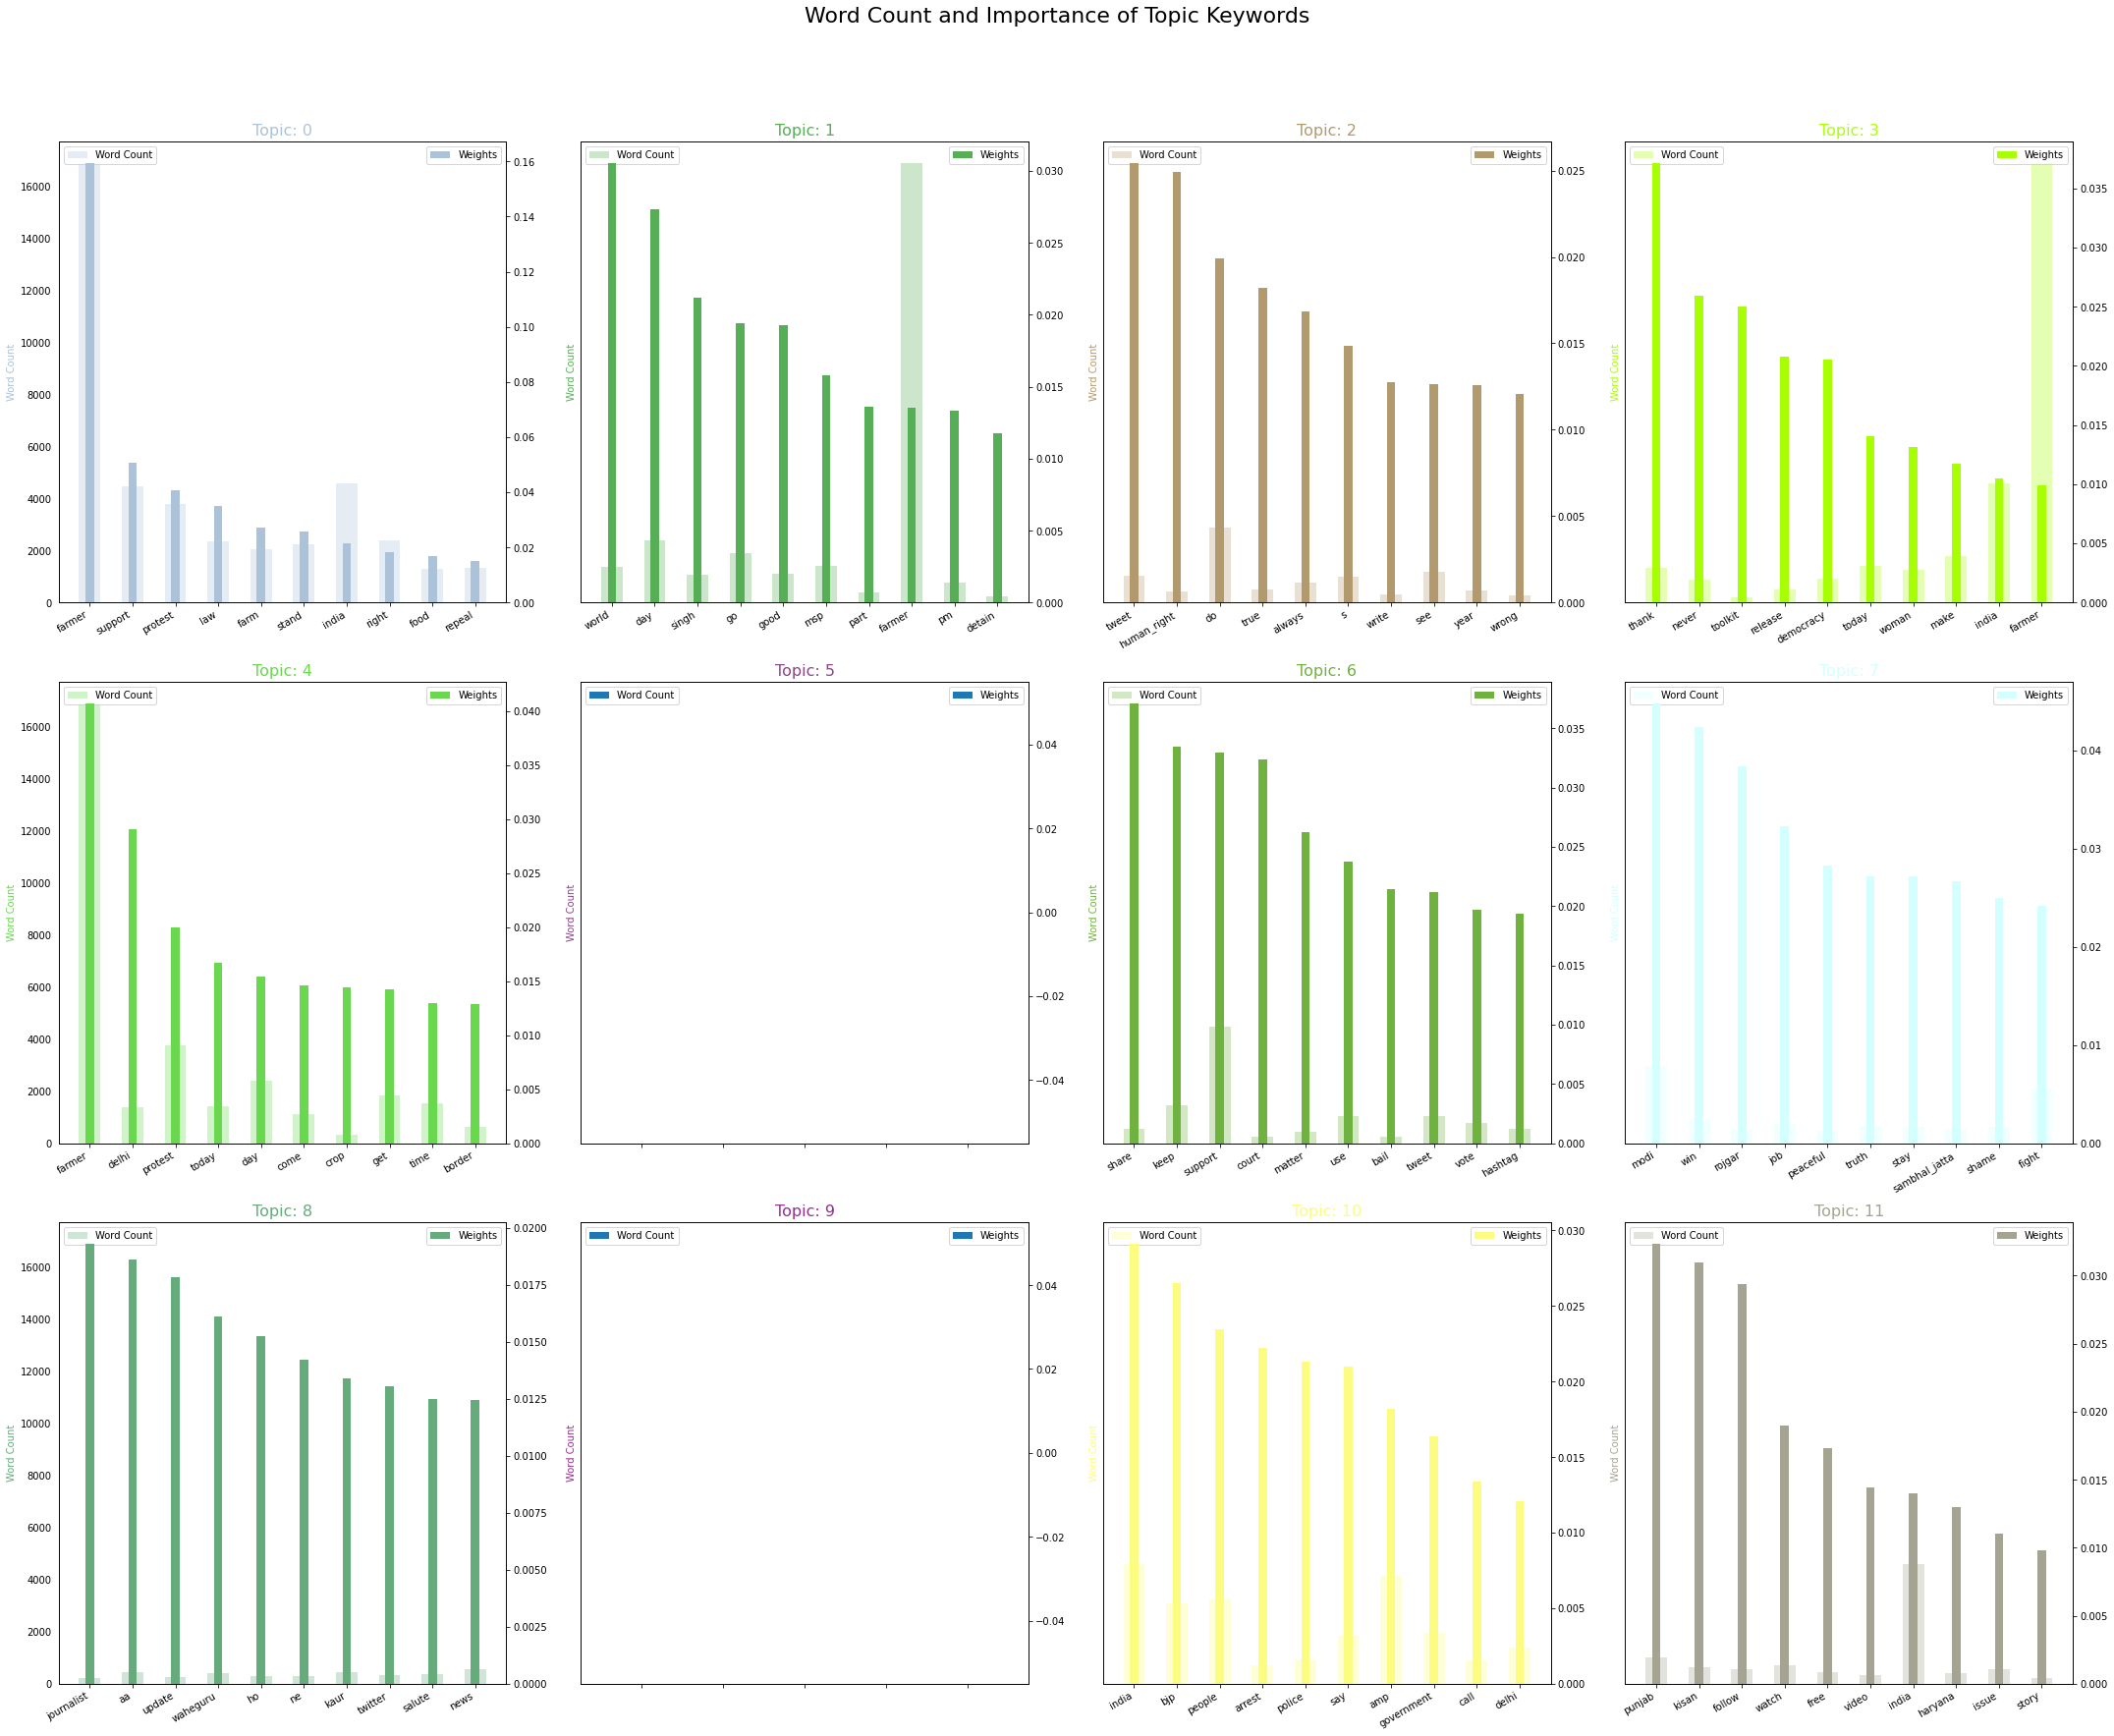

In [20]:
from collections import Counter
topics = optimal_model.show_topics(formatted=False)
data_flat = [w for w_list in texts for w in w_list]
counter = Counter(data_flat)

out = []
for i, topic in topics:
    for word, weight in topic:
        out.append([word, i , weight, counter[word]])

df = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])        

# Plot Word Count and Weights of Topic Keywords
fig, axes = plt.subplots((num_topics//4)+1, 4, figsize=(30,30), sharey=True)
for i, ax in enumerate(axes.flatten()):
    if i<num_topics:
        ax.bar(x='word', height="word_count", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.5, alpha=0.3, label='Word Count')
        ax_twin = ax.twinx()
        ax_twin.bar(x='word', height="importance", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.2, label='Weights')
        ax.set_ylabel('Word Count', color=cols[i])
#         ax_twin.set_ylim(0, 0.030); ax.set_ylim(0, 3500)
        ax.set_title('Topic: ' + str(i), color=cols[i], fontsize=16)
        ax.tick_params(axis='y', left=False)
        ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
        ax.legend(loc='upper left'); ax_twin.legend(loc='upper right')
    else:
        ax.set_visible(False)
        

fig.tight_layout(w_pad=2)    
fig.suptitle('Word Count and Importance of Topic Keywords', fontsize=22, y=1.05)    
plt.show()

### Compute Model Perplexity and Coherence Score

In [21]:
# Compute Perplexity
print('\nPerplexity: ', optimal_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=optimal_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -10.198357548781937

Coherence Score:  0.3463437259858943


### t-distributed stochastic neighbor embedding Clustering Chart

In [22]:
# Get topic weights and dominant topics ------------
from sklearn.manifold import TSNE
from bokeh.plotting import figure, output_file, show
from bokeh.models import Label
from bokeh.io import output_notebook

# Get topic weights
topic_weights = []
for i, row_list in enumerate(optimal_model[corpus]):
    row = row_list[0] if optimal_model.per_word_topics else row_list 
    topic_weights.append([w for i, w in row])

# Array of topic weights    
arr = pd.DataFrame(topic_weights).fillna(0).values

# Keep the well separated points (optional)
arr = arr[np.amax(arr, axis=1) > 0.35]

# Dominant topic number in each doc
topic_num = np.argmax(arr, axis=1)

# tSNE Dimension Reduction
tsne_model = TSNE(n_components=2, verbose=1, random_state=0, angle=.99, init='pca')
tsne_lda = tsne_model.fit_transform(arr)

# Plot the Topic Clusters using Bokeh
output_notebook()
plot = figure(title="t-SNE Clustering of {} LDA Topics".format(num_topics), 
              plot_width=900, plot_height=700)
plot.scatter(x=tsne_lda[:,0], y=tsne_lda[:,1], color=cols[topic_num])
show(plot)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 39938 samples in 0.121s...
[t-SNE] Computed neighbors for 39938 samples in 8.267s...
[t-SNE] Computed conditional probabilities for sample 1000 / 39938
[t-SNE] Computed conditional probabilities for sample 2000 / 39938
[t-SNE] Computed conditional probabilities for sample 3000 / 39938
[t-SNE] Computed conditional probabilities for sample 4000 / 39938
[t-SNE] Computed conditional probabilities for sample 5000 / 39938
[t-SNE] Computed conditional probabilities for sample 6000 / 39938
[t-SNE] Computed conditional probabilities for sample 7000 / 39938
[t-SNE] Computed conditional probabilities for sample 8000 / 39938
[t-SNE] Computed conditional probabilities for sample 9000 / 39938
[t-SNE] Computed conditional probabilities for sample 10000 / 39938
[t-SNE] Computed conditional probabilities for sample 11000 / 39938
[t-SNE] Computed conditional probabilities for sample 12000 / 39938
[t-SNE] Computed conditional probabilities for sam

Loading BokehJS ...

In [23]:
import os
import pyLDAvis.gensim
import pickle 
import pyLDAvis

pyLDAvis.enable_notebook()

LDAvis_data_filepath = os.path.join('./topic-modelled')

LDAvis_prepared = pyLDAvis.gensim.prepare(optimal_model, corpus, id2word)
with open(LDAvis_data_filepath, 'wb') as f:
  pickle.dump(LDAvis_prepared, f)

with open(LDAvis_data_filepath, 'rb') as f:
  LDAvis_prepared = pickle.load(f)

pyLDAvis.save_html(LDAvis_prepared, './topic-modelled.html')

LDAvis_prepared

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.192775  0.082288  1       1        17.285149
10     0.171899  0.014003  2       1        15.102425
5      0.175563  0.049781  3       1        11.948169
1      0.065563 -0.022463  4       1        7.806894 
3      0.099661 -0.079953  5       1        7.591863 
4      0.084229 -0.061409  6       1        7.558744 
2      0.011557 -0.082670  7       1        6.028429 
8     -0.273517 -0.167281  8       1        5.737486 
9     -0.160697 -0.007385  9       1        5.644973 
11    -0.043757 -0.094918  10      1        5.640124 
7     -0.171473  0.323698  11      1        5.241358 
6     -0.151805  0.046307  12      1        4.414385 , topic_info=           Term          Freq         Total Category  logprob  loglift
5     farmer     16986.000000  16986.000000  Default  30.0000  30.0000
145   support    5245.000000   5245.000000   Default  29.0000  29.0000
20    law        2748.000000   2748.000000   Default  28.0000  28.0000
204   hai        1484.000000   1484.000000   Default  27.0000  27.0000
17    farm       2124.000000   2124.000000   Default  26.0000  26.0000
...    ...               ...           ...       ...      ...      ...
1020  tweet      421.982501    1206.154867   Topic12 -3.8564   2.0701 
145   support    657.221573    5245.440696   Topic12 -3.4133   1.0432 
833   political  180.432394    371.327996    Topic12 -4.7060   2.3986 
996   fear       146.508110    234.127176    Topic12 -4.9143   2.6515 
5     farmer     171.361792    16986.254496  Topic12 -4.7576  -1.4761 

[699 rows x 6 columns], token_table=      Topic      Freq           Term
term                                
802   8      0.995442  aa           
1913  11     0.996125  aap          
499   7      0.996084  absolutely   
1090  2      0.950539  abuse        
1090  9      0.048281  abuse        
...  ..           ...    ...        
147   11     0.009782  year         
489   1      0.013314  yogendrayadav
489   11     0.980823  yogendrayadav
1730  2      0.997255  youth        
4194  4      0.994149  zindabad     

[1749 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 11, 6, 2, 4, 5, 3, 9, 10, 12, 8, 7])

### Topics:
1) Repeal the farmers bill - Stand with farmers
2) World sikh day, Minimum support price - Farmers being detained 
3) Write and share about human right violations
4) Toolkit for farmers bill - release the charges on the developers
5) Farmers protest reached Delhi border
6) Raise voice for Indian farmers
7) Keep supporting and sharing farmers protest - Court grant bail to arrested farmers
8) Peaceful fiht against Modi government
9) Journalists and news channels supporting farmers protests
10) Farmers overcoming water shortage - which happened due to road bloack by gov as election closes by
11) Indian BJP government police arrest.
12) Share and support farmers - Court gives bail to farmer protesters

## Sentiment of the crowd towards towards these topics

/Users/abhinav/.pyenv/versions/3.8.7/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/Users/abhinav/.pyenv/versions/3.8.7/lib/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:1434: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  self.tick_pos = ax.

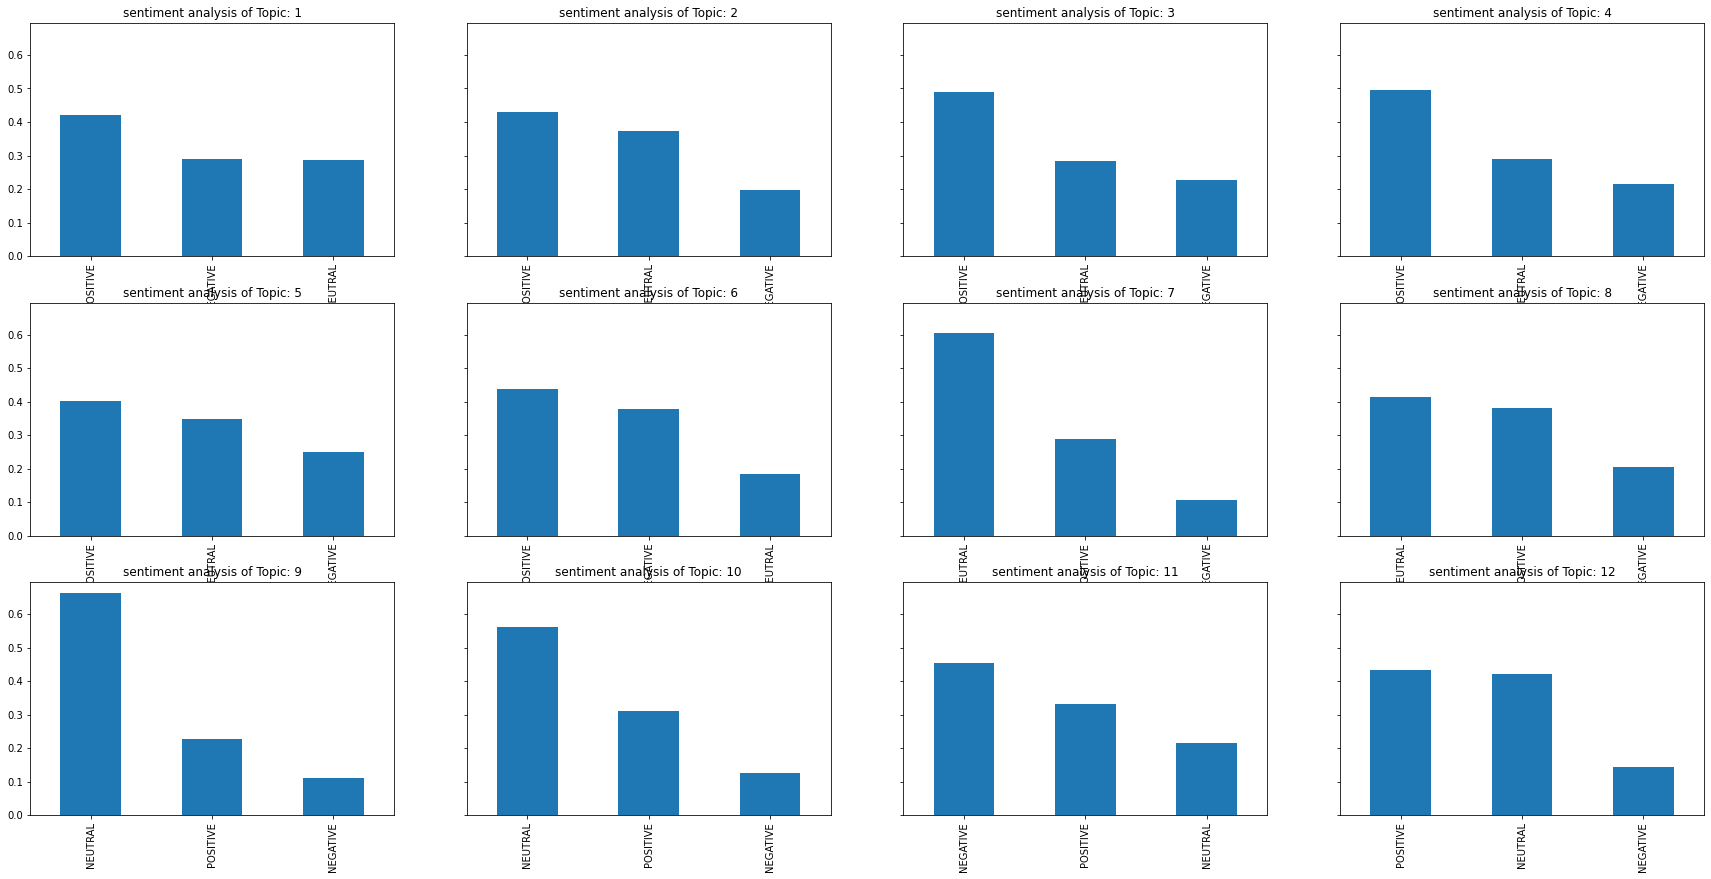

In [41]:
Topics =  list(sent_topics_outdf_grpd)
fig, axes = plt.subplots(6, 4, figsize=(30,30), sharey=True)
for i, ax in enumerate(axes.flatten()):
    if i<num_topics:
        topic = Topics[i][1]
        sid = SentimentIntensityAnalyzer()
        df = pd.DataFrame()
        df["text_processed"]=topic[0].to_numpy()
        df['scores'] = df['text_processed'].apply(lambda text_processed: sid.polarity_scores(text_processed))

        df['compound'] = df['scores'].apply(lambda score_dict: score_dict['compound'])
        df['sentiment_type']=''
        df.loc[df.compound>0,'sentiment_type']='POSITIVE'
        df.loc[df.compound==0 ,'sentiment_type']='NEUTRAL'
        df.loc[df.compound<0,'sentiment_type']='NEGATIVE'
        df.sentiment_type.value_counts(normalize=True).plot.bar(ax=ax,title="sentiment analysis of Topic: "+str(i+1))
    else:
        ax.set_visible(False)

## Top Celebrities tweeted regarding #FarmersProtest
Chores: 
* Once the new data is available repeat the same

In [25]:
raw_tweets_celeb = pd.read_csv('raw_tweets_celebs.csv')
raw_tweets_celeb.head(10)

/Users/abhinav/.pyenv/versions/3.8.7/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,id,created_at,text,retweet_count,favorite_count,user_screen_name,user_followers_count,user_verified,country
0,1376910980345589761,2021-03-30 14:55:34,"#FarmersProtest \n\n👉Mitti Satyagraha Yatra from March 30-April 6\n\n👉To begin from Gujarat's Dandi where Gandhi ended Salt March\n\n👉Will pass from Bihar, MP, Assam,\nMaha, Bengal, Odisha, UP, R'than, UK &amp; Punjab\n\n👉Soil to be used to build martyr memorial at Singhu for 310+ farmers",221,597,saahilmenghani,86804,True,India
1,1376468273013813250,2021-03-29 09:36:24,Ouch! #Colourful Happy Holi at Singhu Border's #FarmersProtest.\n\nDon't miss the ending! https://t.co/EWBylEbTfB,244,1131,saahilmenghani,86804,True,India
2,1376573149257461762,2021-03-29 16:33:08,"#TrendingTonight | ""If we stop protesting, it will ruin our future. We have no choice but to continue the movement"": Naresh Tikait, President, Bhartiya Kisan Union \n\n#FarmersProtest https://t.co/YplaqdvUxg",74,396,ndtv,14920393,True,India
3,1376205351058464768,2021-03-28 16:11:39,#Breaking\n\n👉Zee Owner Subhash Chandra had an event today in Hisar\n\n👉100s of Farmers gheroed the venue &amp; forced Chandra to cancel it\n\n👉Event organizers apologize to farmers for inviting him\n\n👉Zee been peddling hate against farmers. #FarmersProtest giving it back to #GodiMedia https://t.co/r330EJCb3c,1246,2894,saahilmenghani,86804,True,India
4,1376302844224102400,2021-03-28 22:39:03,So many people from so many countries are now supporting the #FarmersProtest 🚜 https://t.co/bRKuo9ngVQ,185,849,Khalsa_Aid,250712,True,Global
5,1376470293351305219,2021-03-29 09:44:26,"Fact Check: #AjayDevgn not the man in viral #Delhibrawl video, clarifies actor's spokesperson\n\n#FarmersProtest #FarmLaws \n\nhttps://t.co/1wLutevgS4",43,148,dna,2229577,True,India
6,1376780207344918528,2021-03-30 06:15:55,"More than 300 Farmers Sacrificed their lives during the #FarmersProtest, but the Govt is still adamant &amp; shamelessly silent . India will never Forget the way, this \nFac!st Govt treating our Farmers. #GoBackModi https://t.co/kO1XKCd1ri",17,47,pycpim,16453,True,"Pondicherry, India"
7,1376573541009649668,2021-03-29 16:34:42,"#TrendingTonight | ""Why would we unleash violence against our own people? Even the roads have been closed by the government, not us"": Naresh Tikait, President, Bhartiya Kisan Union \n\n#FarmersProtest https://t.co/esW0juCQTp",29,159,ndtv,14920393,True,India
8,1376572897590870021,2021-03-29 16:32:08,"#TrendingTonight | ""Protests are continuing, all farmers are united"": Naresh Tikait, President, Bhartiya Kisan Union \n\n#FarmersProtest https://t.co/92XiZPQ4np",39,204,ndtv,14920393,True,India
9,1376751476589043713,2021-03-30 04:21:45,"""If we stop protesting, it will ruin our future. We have no choice but to continue the movement"": Naresh Tikait, President, Bhartiya Kisan Union \n\nWatch more here: https://t.co/qwgGHe4v2w\n\n#FarmersProtest #FarmersProtest_BharatBandh #BharatBandh https://t.co/3usDPopJ9S",24,169,sanket,122437,True,Delhi | Ayodhya


In [26]:
tweets_df = raw_tweets_celeb.copy()
tweets_df['text_processed'] = raw_tweets_celeb['text']

# Remove any links
tweets_df['text_processed'] = tweets_df['text_processed'].map(lambda x: re.sub(r'http\S+', '', x))

# Remove any timestamps
tweets_df['text_processed'] = tweets_df['text_processed'].map(lambda x: re.sub(r'[0-9]{1,2}:[0-9]{1,2}:[0-9]{1,2}', '', x))

# Remove punctuation
tweets_df['text_processed'] = tweets_df['text_processed'].map(lambda x: re.sub('[=,:;\\.!|\-\_"}{}]', ' ', x))

# Convert remove apostrophe from words
tweets_df['text_processed'] = tweets_df['text_processed'].map(lambda x: re.sub('[\']', '', x))

# Remove unnecessary line breaks
tweets_df['text_processed'] = tweets_df['text_processed'].map(lambda x: re.sub(r"\n", '', x))

# Remove any emojis or non-english alphabet
# (!) NOTE: this removes hindi words too
tweets_df['text_processed'] = tweets_df['text_processed'].map(lambda x: re.sub(r'[^\x00-\x7F]+', '', x))

# Remove any twitter handles
tweets_df['text_processed'] = tweets_df['text_processed'].map(lambda x: re.sub('@[\w]*', '', x))

# Remove any hashtags
tweets_df['text_processed'] = tweets_df['text_processed'].map(lambda x: re.sub('#[\w]*', '', x))

# Remove leading spaces
tweets_df['text_processed'] = tweets_df['text_processed'].map(lambda x: re.sub(r'^\s+', '', x))

# Remove trailing spaces
tweets_df['text_processed'] = tweets_df['text_processed'].map(lambda x: re.sub(r'[ \t]+$', '', x))

# Remove multi spaces
tweets_df['text_processed'] = tweets_df['text_processed'].map(lambda x: re.sub(' +', ' ', x))

# Remove small words (words like "a", "ok", "are", "in" are useless)
# min_word_length = 3
# tweets_df['text_processed'] = tweets_df['text_processed'].map(lambda x: ' '.join([word for word in x.split() if len(word)>min_word_length]))

# Remove duplicate tweets (keep latest)
tweets_df = tweets_df.drop_duplicates(subset='text_processed', keep="last")

# Remove any empty columns after all the processing
tweets_df['text_processed'].replace('', np.nan, inplace=True)
tweets_df.dropna(subset=['text_processed'], inplace=True)
 
# Store as CSV for later, tweets_df will contain the headers
processed_tweets_df = pd.DataFrame(data=tweets_df)
print(processed_tweets_df['text_processed'].head())
processed_tweets_df.to_csv("preprocessed_tweets_celeb", quotechar='"', encoding='utf8', index = False, header=True)

0    Mitti Satyagraha Yatra from March 30 April 6To begin from Gujarats Dandi where Gandhi ended Salt MarchWill pass from Bihar MP Assam Maha Bengal Odisha UP Rthan UK &amp PunjabSoil to be used to build martyr memorial at Singhu for 310+ farmers
1    Ouch Happy Holi at Singhu Borders Dont miss the ending                                                                                                                                                                                           
2    If we stop protesting it will ruin our future We have no choice but to continue the movement Naresh Tikait President Bhartiya Kisan Union                                                                                                        
3    Owner Subhash Chandra had an event today in Hisar100s of Farmers gheroed the venue &amp forced Chandra to cancel itEvent organizers apologize to farmers for inviting himZee been peddling hate against farmers giving it back to                
4    So many

/Users/abhinav/.pyenv/versions/3.8.7/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<>:11: DeprecationWarning: invalid escape sequence \-
<>:24: DeprecationWarning: invalid escape sequence \w
<>:27: DeprecationWarning: invalid escape sequence \w
<>:11: DeprecationWarning: invalid escape sequence \-
<>:24: DeprecationWarning: invalid escape sequence \w
<>:27: DeprecationWarning: invalid escape sequence \w
<ipython-input-26-3080009bb30e>:11: DeprecationWarning: invalid escape sequence \-
  tweets_df['text_processed'] = tweets_df['text_processed'].map(lambda x: re.sub('[=,:;\\.!|\-\_"}{}]', ' ', x))
<ipython-input-26-3080009bb30e>:24: DeprecationWarning: invalid escape sequence \w
  tweets_df['text

In [27]:
top_celeb_tweets = processed_tweets_df.iloc[processed_tweets_df.groupby('user_screen_name', group_keys=False)["retweet_count"].nlargest(1).index][["id","user_screen_name","text_processed"]].reset_index(drop=True)
top_celeb_tweets.head(10)

/Users/abhinav/.pyenv/versions/3.8.7/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,id,user_screen_name,text_processed
0,1376196587379036160,ChitraSarwara,At Tikri border the spirit that strives for farmers rights has built a small shelter that also serves as a classroom for kids from adjoining Slums at designated timings Amazing work by shelter build by hand
1,1374372441330388998,ClaudiaWebbe,Farmers ProtestTheir struggle is our struggleI asked the UK Government what action it will take with social media companies to tackle online abuse directed at those supporting Indian Farmers Here is their response
2,1374403274342690824,Khalsa_Aid,A very successful event at the Well done to the organisers and the amazing volunteers
3,1375901131986075651,RaviSinghKA,WARNING Partial Nudity BJP MLA from Abohar Arun Narang who continually called the protesting farmers as Khalistani faced the anger of the farmers
4,1374286462712041472,TabeenahAnjum,Farmers hold placards at a Kisan Mahapanchayat in Jaipurs Vidhyadhar Nagar where BKU leader is addressing a Mahasabha (meet)This is Tikaits maiden rally in Jaipur Earlier he held mahapanchayats in around 11 districts of
5,1374235205985243138,_gurjotsandhu,Donating blood on the 90th Death Anniversary of Shaheed Bhagat Singh Rajguru &amp Sukhdev organised by
6,1374417073359622162,abhijeet_dipke,So is being punished for standing in support of this video to know why BJP is curtailing Delhi Govts power
7,1374068683849408519,ambkcsingh,Significantly over 81% oppose farm laws Imagine in Tamil Nadu Let BJP figure that out as they maintain is localised in Punjab Delhi belt
8,1376801097042436100,anitanairauthor,Just in case it has skipped anyone s mind the farmers continue to be out there protesting about the farm laws More than ever we need to remember and support the farmers
9,1376470293351305219,dna,Fact Check not the man in viral video clarifies actors spokesperson


### Analyse the sentiment towards these tweets from replies

In [28]:
raw_tweets_celeb_repl = pd.read_csv('raw_tweets_celebs_replies.csv')
raw_tweets_celeb_repl.head(10)

/Users/abhinav/.pyenv/versions/3.8.7/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,related_id,id,created_at,text,retweet_count,favorite_count,user_screen_name,user_followers_count,user_verified,country
0,1376910980345589761,1376915995751710727,2021-03-30 15:15:29,"@saahilmenghani @saahilmenghani Just that you mentioned that soil to be used to build martyr memorial at Singhu, reminds me of your beautiful story from 23rd March on Martys Day only, when you reported that soils from sites like Sri Anandpur Sahib, Jallianwala Bagh brought to Singhu, Tikri🙏❤",1,3,rituraj_prht,256,False,India
1,1376910980345589761,1376914515191758852,2021-03-30 15:09:36,@saahilmenghani Very good decision.\nHope every leader joins it!,0,1,POLL__ARISED,15,False,In middle of Farmers Protest
2,1376910980345589761,1376912358480642055,2021-03-30 15:01:02,"Inspired by India's greatest son, Mahatma Gandhi, farmers to launch\nPan-India Mitti Satyagrah yatra from\nGujarat's Dandi. Details 👇\n\nhttps://t.co/AObknDHBf2",65,221,saahilmenghani,86809,True,India
3,1376910980345589761,1376911769118121989,2021-03-30 14:58:42,@saahilmenghani This sounds really great!,0,2,Simran_R,209,False,Somewhere in the diaspora...
4,1376468273013813250,1376737645187895298,2021-03-30 03:26:47,@saahilmenghani Why are these women hitting the men? What’s the significance??? I want to play Holi everyday if I can do this 😂😂,0,0,GG309577,94,False,NaN
5,1376468273013813250,1376597762188308482,2021-03-29 18:10:57,@saahilmenghani Nice..,0,0,dpsisi,1045,False,NaN
6,1376468273013813250,1376547719985041413,2021-03-29 14:52:06,@saahilmenghani Superb,0,0,diamondhorse19,111,False,NaN
7,1376468273013813250,1376526151674339335,2021-03-29 13:26:23,@saahilmenghani Happy Holi Saahil Bhai😎,0,1,Sandy_26Nov,56,False,"Lucknow, India"
8,1376468273013813250,1376503679709155337,2021-03-29 11:57:06,@saahilmenghani @Rohit245_ 😂 haryanvi women plaing holi with Punjabi farmers in haryana style,0,1,AshokSGarcha,5672,False,"Ludhiana, India"
9,1376468273013813250,1376503554702073860,2021-03-29 11:56:36,"@saahilmenghani Ye hoti hai Holi, revenge time😂❤️",0,0,iScienceFan,30,False,Espoo


In [29]:
tweets_df = raw_tweets_celeb_repl.copy()
tweets_df['text_processed'] = raw_tweets_celeb_repl['text']

# Remove any links
tweets_df['text_processed'] = tweets_df['text_processed'].map(lambda x: re.sub(r'http\S+', '', x))

# Remove any timestamps
tweets_df['text_processed'] = tweets_df['text_processed'].map(lambda x: re.sub(r'[0-9]{1,2}:[0-9]{1,2}:[0-9]{1,2}', '', x))

# Remove punctuation
tweets_df['text_processed'] = tweets_df['text_processed'].map(lambda x: re.sub('[=,:;\\.!|\-\_"}{}]', ' ', x))

# Convert remove apostrophe from words
tweets_df['text_processed'] = tweets_df['text_processed'].map(lambda x: re.sub('[\']', '', x))

# Remove unnecessary line breaks
tweets_df['text_processed'] = tweets_df['text_processed'].map(lambda x: re.sub(r"\n", '', x))

# Remove any emojis or non-english alphabet
# (!) NOTE: this removes hindi words too
tweets_df['text_processed'] = tweets_df['text_processed'].map(lambda x: re.sub(r'[^\x00-\x7F]+', '', x))

# Remove any twitter handles
tweets_df['text_processed'] = tweets_df['text_processed'].map(lambda x: re.sub('@[\w]*', '', x))

# Remove any hashtags
tweets_df['text_processed'] = tweets_df['text_processed'].map(lambda x: re.sub('#[\w]*', '', x))

# Remove leading spaces
tweets_df['text_processed'] = tweets_df['text_processed'].map(lambda x: re.sub(r'^\s+', '', x))

# Remove trailing spaces
tweets_df['text_processed'] = tweets_df['text_processed'].map(lambda x: re.sub(r'[ \t]+$', '', x))

# Remove multi spaces
tweets_df['text_processed'] = tweets_df['text_processed'].map(lambda x: re.sub(' +', ' ', x))

# Remove small words (words like "a", "ok", "are", "in" are useless)
# min_word_length = 3
# tweets_df['text_processed'] = tweets_df['text_processed'].map(lambda x: ' '.join([word for word in x.split() if len(word)>min_word_length]))

# Remove duplicate tweets (keep latest)
tweets_df = tweets_df.drop_duplicates(subset='text_processed', keep="last")

# Remove any empty columns after all the processing
tweets_df['text_processed'].replace('', np.nan, inplace=True)
tweets_df.dropna(subset=['text_processed'], inplace=True)
 
# Store as CSV for later, tweets_df will contain the headers
processed_tweets_df_replies = pd.DataFrame(data=tweets_df)
print(processed_tweets_df_replies['text_processed'].head())
processed_tweets_df_replies.to_csv("preprocessed_tweets_celeb", quotechar='"', encoding='utf8', index = False, header=True)

/Users/abhinav/.pyenv/versions/3.8.7/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<>:11: DeprecationWarning: invalid escape sequence \-
<>:24: DeprecationWarning: invalid escape sequence \w
<>:27: DeprecationWarning: invalid escape sequence \w
<>:11: DeprecationWarning: invalid escape sequence \-
<>:24: DeprecationWarning: invalid escape sequence \w
<>:27: DeprecationWarning: invalid escape sequence \w
<ipython-input-29-d768027351d4>:11: DeprecationWarning: invalid escape sequence \-
  tweets_df['text_processed'] = tweets_df['text_processed'].map(lambda x: re.sub('[=,:;\\.!|\-\_"}{}]', ' ', x))
<ipython-input-29-d768027351d4>:24: DeprecationWarning: invalid escape sequence \w
  tweets_df['text

0    Just that you mentioned that soil to be used to build martyr memorial at Singhu reminds me of your beautiful story from 23rd March on Martys Day only when you reported that soils from sites like Sri Anandpur Sahib Jallianwala Bagh brought to Singhu Tikri
1    Very good decision Hope every leader joins it                                                                                                                                                                                                                 
2    Inspired by Indias greatest son Mahatma Gandhi farmers to launchPan India Mitti Satyagrah yatra fromGujarats Dandi Details                                                                                                                                    
3    This sounds really great                                                                                                                                                                                               

/Users/abhinav/.pyenv/versions/3.8.7/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/Users/abhinav/.pyenv/versions/3.8.7/lib/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:1434: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  self.tick_pos = ax.

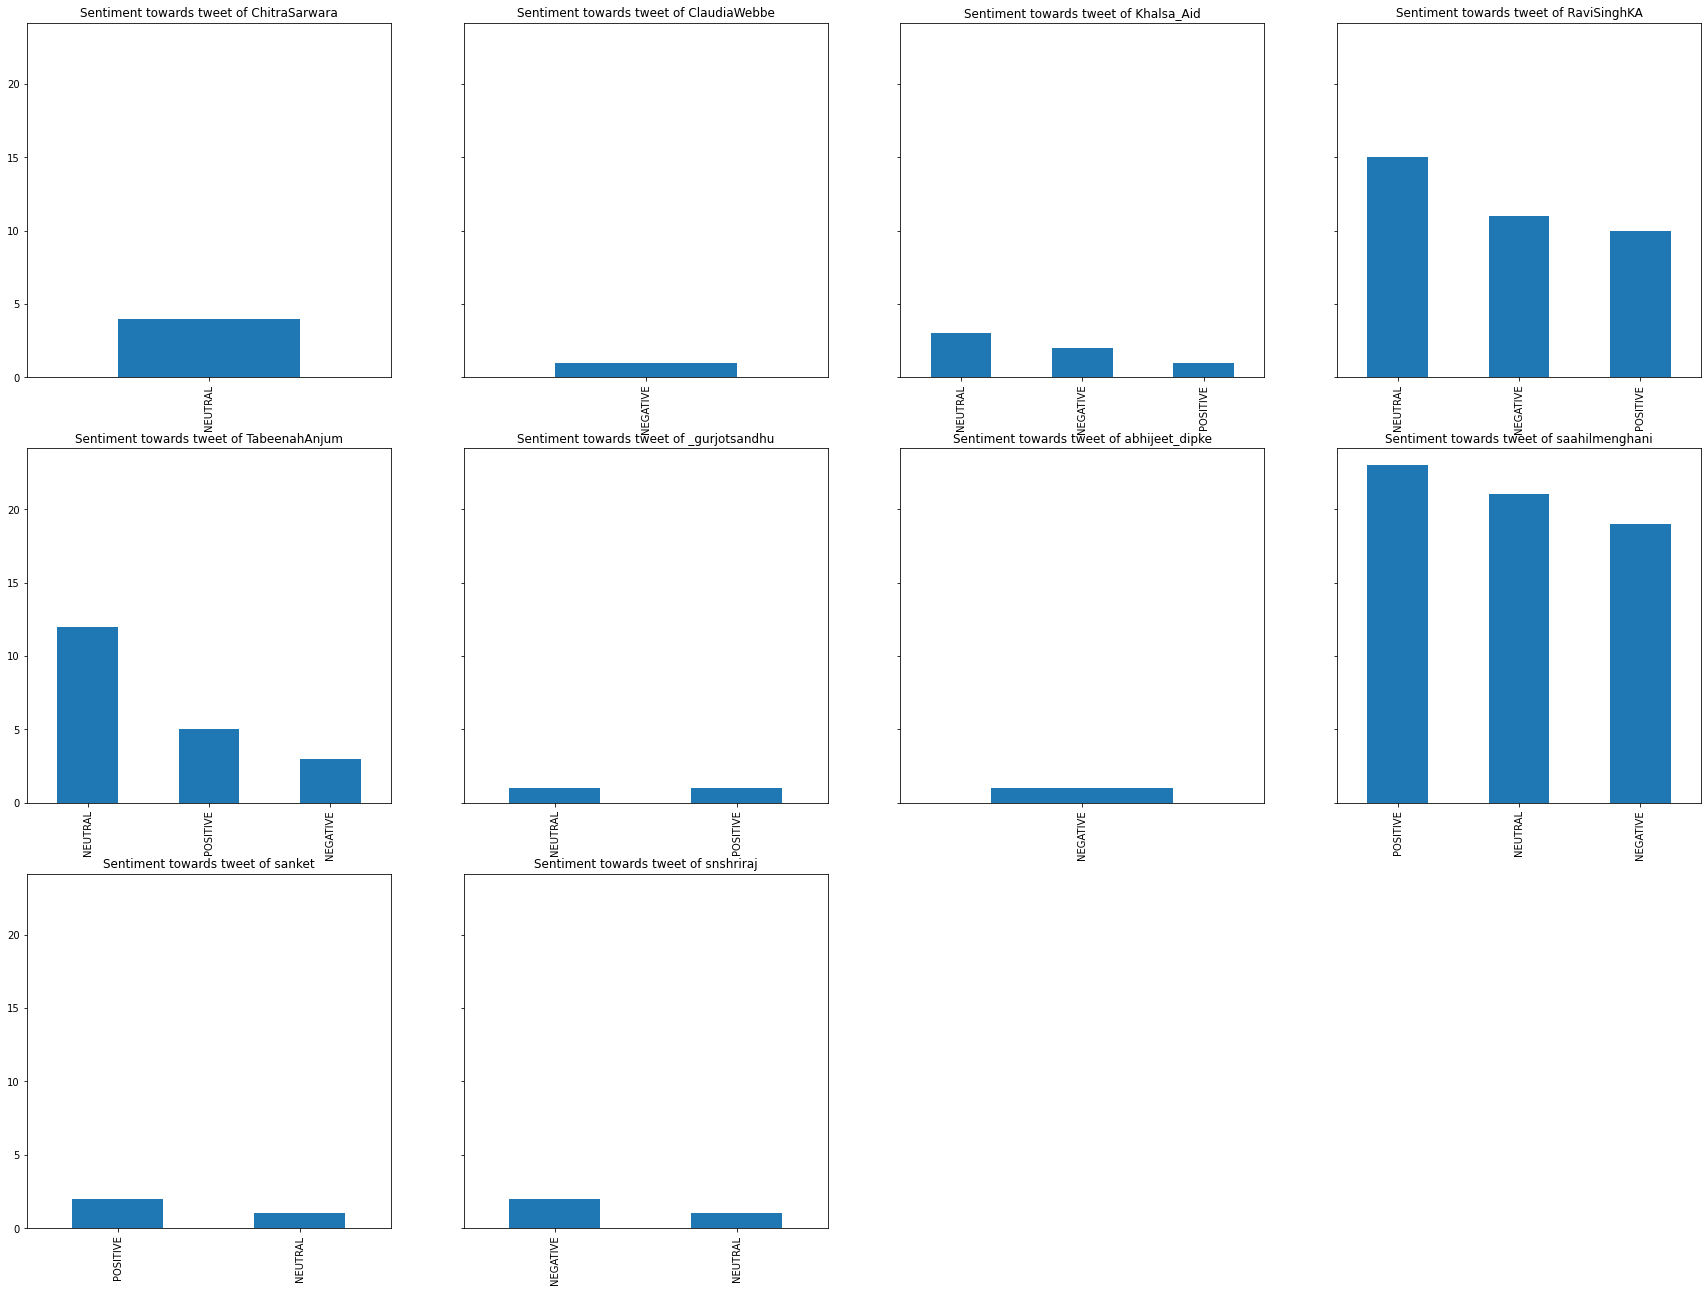

In [44]:
fig, axes = plt.subplots(top_celeb_tweets.shape[0]//4, 4, figsize=(30,30), sharey=True)
axises = axes.flatten()
i=0
for index, row in top_celeb_tweets.iterrows():
    processed_tweets_df_reply = processed_tweets_df_replies[processed_tweets_df_replies["related_id"]==row['id']]
    df = pd.DataFrame()
    df["text_processed"]=processed_tweets_df_reply["text_processed"].to_numpy()
    if df.shape[0]<1:
        continue
    df['scores'] = df['text_processed'].apply(lambda text_processed: sid.polarity_scores(text_processed))
    df['compound'] = df['scores'].apply(lambda score_dict: score_dict['compound'])
    df['sentiment_type']=''
    df.loc[df.compound>0,'sentiment_type']='POSITIVE'
    df.loc[df.compound==0 ,'sentiment_type']='NEUTRAL'
    df.loc[df.compound<0,'sentiment_type']='NEGATIVE'
    df.sentiment_type.value_counts().plot.bar(ax=axises[i],title="Sentiment towards tweet of "+row['user_screen_name'])
    i+=1
for ax in axises[i:]:
    ax.set_visible(False)

#### Couldn't identify the political stand of celbrities using NER even after custom training the NER model for detecting political parties and making use of Wikidata. Skipping this part from the scope of coursework

### Named Entity Recognition

In [ ]:
import spacy
import en_core_web_trf

In [ ]:

Topics = ['bjp', 'repeal', 'modi', 'protest','farm laws']

for i in Topics:
    
    df = pd.read_csv('preprocessed_tweets.csv', quotechar='"', encoding='utf8')
    
    sub = i
    
    df['indexes'] = df['text_processed'].str.find(sub)
    
    # Get names of indexes which does not have the topic
    indexNames = df[ df['indexes'] == -1 ].index
    # Delete these row indexes from dataFrame
    df.drop(indexNames , inplace=True)
    #save for NER
    unique_tweets = df

unique_tweets_list = list(unique_tweets['text_processed'].values)

#Use a spacy model trained using our own dataset
nlp = spacy.load(r".\spacy_trained_model")


entities = list()

for tweet_text in unique_tweets_list:
  doc = nlp(tweet_text)
  for ne in doc.ents:
    print('\tNE found: ', ne.start_char, ne.end_char, ne.label_, ne.text,"--",tweet_text)
    entities.append(ne.text)

#print(entities)